## Imports

In [19]:
#Imports
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import contextily as cx
from datetime import datetime, timedelta
import fsspec
from geographiclib.geodesic import Geodesic
#need to have google-api-python-client, google-cloud-storage, and gcloud
#installed
from google.cloud import storage
import h5py
from itertools import repeat
import numpy as np
import os
import pandas as pd
from pyproj import Geod
from scipy import interpolate
import shutil
#need to have netcdf4 and h5netcdf installed
import xarray as xr

## Methods for Reading Best Track Data

In [20]:
def read_best_track(bt_url, start_datetime, end_datetime):
    """
    Parse best track files and extract hurricane intensity and position info

    Args:
        bt_url: URL of hurricane best track file
        start_datetime: Start datetime of data to download
        end_datetime: End datetime of data to download
    
    Returns:
        Dataframe containing intensity/position data from best track file
    """
    #Array to store hurricane location data
    hurr_info_array = []
    #Open best track file in fsspec
    with fsspec.open(bt_url, mode="rt") as fobj:
        #Loop through hurricanes
        while True:
            #Data includes a combination of timestamp data and overall hurricane
            #data. 
            #File format: https://www.aoml.noaa.gov/hrd/hurdat/hurdat2-format.pdf

            hurr_info = fobj.readline()
            #print(hurr_info)

            #If the end of the file is reached readline() returns an empty 
            #string.
            if not hurr_info:
                break
        
            hurr_code, hurr_name, n_lines = hurr_info.replace(" ", "").split(",")[:-1]
            #Loop through timestamps within each hurricane
            for row in range(int(n_lines)):
                timestamp_info = fobj.readline()
                #print(timestamp_info)
                ts_day, ts_min, record_identifier, sys_status, lat_hem, lon_hem,\
                max_sust, min_pres, rad34_ne, rad34_se, rad34_sw, rad34_nw,\
                rad50_ne, rad50_se, rad50_sw, rad50_nw, rad64_ne, rad64_se,\
                rad64_sw, rad64_nw, rad_mw = timestamp_info.replace(" ", "").replace("\n", "").split(",")
                #print(rad_mw)
                #Data we want to store

                #Parse timestamps - only continue if timestamp is in desired
                #range
                ts_full = datetime.strptime((ts_day+ts_min),"%Y%m%d%H%M")
                #print(ts_full, start_datetime, ts_max)
                if ((ts_full < start_datetime) or (ts_full > end_datetime)):
                    continue
                
                #Parse lat/lon (convert coords with hemisphere to absolute)
                lat = float(lat_hem[:-1])
                hem = lat_hem[-1]
                if hem != 'N':
                    lat *= -1

                lon = float(lon_hem[:-1])
                hem = lon_hem[-1]
                if hem != 'E':
                    lon *= -1

                timestamp_info_array = [hurr_code, hurr_name, ts_full, sys_status,
                                        lat, lon, max_sust, min_pres,
                                        rad_mw]
                hurr_info_array.append(timestamp_info_array)
    
    #Convert hurr_info_array into a dataframe
    hurr_info_df = pd.DataFrame(hurr_info_array,
                                 columns = ['Hurricane Code', 'Hurricane Name',
                                            'Timestamp', 'Status', 'Latitude',
                                            'Longitude',
                                            'Maximum Sustained Winds', 
                                            'Minimum Pressure', 
                                            'Radius of Maximum Winds'])
    
    return hurr_info_df

In [21]:
def interpolate_hurr_info(hurricane_data_df, bin_times, bin_starts, bin_ends, geod):
    """
    Interpolate hurricane data df to get storm info at specified times.
    Lat/lon coordinates are interpolated between nearest best-track points, 
    other fields simply are assigned the value of the nearest timestamp.

    Note: bin_times, bin_starts, and bin_ends must be the same length

    Args:
        hurricane_data_df: Dataframe of hurricane info (created by merging best
            track and SHIPS data). Should be filtered to one storm)
        bin_times: List of midpoint datetimes of bins where interpolated data is 
            needed
        bin_starts: List of start datetimes of bins
        bin_ends: List of end datetimes of bins
        geod: Geographic datum to use for calculating storm motion direction
        
    
    Returns:
        Dataframe containing interpolated hurricane info for times in bin_times
    """
    #Initialize df to return
    hurr_info_interp_df = pd.DataFrame(bin_times, columns = ['Timestamp'])

    #Turn timestamp lists into numerical format
    bin_times_num = [bin_time.timestamp() for bin_time in bin_times]
    bin_starts_num = [bin_start.timestamp() for bin_start in bin_starts]
    bin_ends_num = [bin_end.timestamp() for bin_end in bin_ends]
    hurricane_data_ts_num = [ts.timestamp() for ts in hurricane_data_df['Timestamp']]

    #Nearest neighbor for hurricane status
    hurr_info_interp_df['Status'] = pd.merge_asof(hurr_info_interp_df['Timestamp'], 
                                                  hurricane_data_df[["Timestamp", "Status"]], 
                                                  on="Timestamp", direction="nearest")['Status']

    #Interpolate latitudes/longitudes
    hurr_info_interp_df['Latitude'] = np.interp(bin_times_num, hurricane_data_ts_num, hurricane_data_df['Latitude'])
    hurr_info_interp_df['Longitude'] = np.interp(bin_times_num, hurricane_data_ts_num, hurricane_data_df['Longitude'])

    #Find storm motion
    #Really janky solution - basically interpolate storm position for start and
    #end times of bin and calculate direction between those
    bin_start_lats = np.interp(bin_starts_num, hurricane_data_ts_num, hurricane_data_df['Latitude'])
    bin_start_lons = np.interp(bin_starts_num, hurricane_data_ts_num, hurricane_data_df['Longitude'])
    bin_end_lats = np.interp(bin_ends_num, hurricane_data_ts_num, hurricane_data_df['Latitude'])
    bin_end_lons = np.interp(bin_ends_num, hurricane_data_ts_num, hurricane_data_df['Longitude'])

    #List to populate with storm motion directions
    sm_dirs, _, dists = geod.inv(bin_start_lons, bin_start_lats, bin_end_lons, bin_end_lats)
    hurr_info_interp_df['Storm Motion Direction (deg)'] = sm_dirs % 360

    #Nearest neighbor interpolation for other storm characteristics
    hurr_info_interp_df['Maximum Sustained Winds'] = pd.merge_asof(hurr_info_interp_df['Timestamp'], 
                                                                   hurricane_data_df[["Timestamp", "Maximum Sustained Winds"]], 
                                                                   on="Timestamp", direction="nearest")['Maximum Sustained Winds']
    
    hurr_info_interp_df['Minimum Pressure'] = pd.merge_asof(hurr_info_interp_df['Timestamp'], 
                                                            hurricane_data_df[["Timestamp", "Minimum Pressure"]], 
                                                            on="Timestamp", direction="nearest")['Minimum Pressure']
    
    hurr_info_interp_df['Radius of Maximum Winds'] = pd.merge_asof(hurr_info_interp_df['Timestamp'], 
                                                                   hurricane_data_df[["Timestamp", "Radius of Maximum Winds"]], 
                                                                   on="Timestamp", direction="nearest")['Radius of Maximum Winds']
    
    hurr_info_interp_df['Shear Magnitude (kts)'] = pd.merge_asof(hurr_info_interp_df['Timestamp'], 
                                                                 hurricane_data_df[["Timestamp", "Shear Magnitude (kts)"]], 
                                                                 on="Timestamp", direction="nearest")['Shear Magnitude (kts)']

    hurr_info_interp_df['Shear Direction (deg)'] = pd.merge_asof(hurr_info_interp_df['Timestamp'], 
                                                                 hurricane_data_df[["Timestamp", "Shear Direction (deg)"]], 
                                                                 on="Timestamp", direction="nearest")['Shear Direction (deg)']     

    return hurr_info_interp_df

    
    
    
    

In [22]:
#def interpolate_path(self, hurricane_name, original_path_df, interval_minutes=30):
#    """
#    Interpolate hurricane track to get lat/lon positions at a specified interval
#    (defaults to 30 minute interval)
#
#    Args:
#        hurricane_name: URL of hurricane best track file (necessary?)
#        original_path_df: dataframe containing original hurricane path
#        interval_minutes: interval in minutes between returned interpolated
#            points
#    
#    Returns:
#        Dataframe containing interpolated hurricane position points
#    """
#    geod = Geodesic.WGS84
#    original_path_df = original_path_df.reset_index(drop=True)
#    interp_points = []
#    self.hurricane_name = hurricane_name
#    for row_i in range(len(original_path_df)-1):
#        point1 = original_path_df.iloc[row_i]
#        point2 = original_path_df.iloc[row_i+1]
#        lat1 = point1["lat"]
#        lon1 = point1["lon"]
#        lat2 = point2["lat"]
#        lon2 = point2["lon"]
#        start_time = point1["time"]
#        end_time = point2["time"]
#        delta_minutes = int((point2["time"] - point1["time"]).total_seconds() / 60)
#        n_steps = delta_minutes // interval_minutes
#
#        line = geod.InverseLine(lat1, lon1, lat2, lon2)
#            
#        # add first point without interpolation
#        if row_i == 0:
#            interp_points.append([start_time, lat1, lon1])
#
#        for point_i in range(1,n_steps):
#            frac = (interval_minutes * point_i) / delta_minutes
#            s = line.s13 * min(frac, 1.0)
#            pos = line.Position(s)
#            t = start_time + dt.timedelta(minutes=interval_minutes*point_i)
#            interp_points.append([t, pos['lat2'], pos['lon2']])
#
#        interp_points.append([end_time, lat2, lon2])
#
#    interp_path_df = pd.DataFrame(interp_points,columns=["time", "lat", "lon"])
#    return interp_path_df

## Methods for Reading SHIPS Data

In [23]:
def find_ships_code(fobj, desired_code):
    """
    Helper function for finding a specific line code in SHIPS data files

    Args:
        hurricane_name: URL of hurricane best track file (necessary?)
        fobj: data file with current pointer
        desired_code: line code of next line we're interested in. We'll just scan
            through the file until we find a line with that code
    
    Returns:
        Returns that line once we find it. If no line is found, returns None
    """
    #Loop through lines of file
    while True:
        ships_info = fobj.readline()
        #print(ships_info)
        #If no line found, we have reached the end of the file. In the run of
        #this program, that should only occur at the end of a section (we would
        #be looking for code 'HEAD' in that instance)
        if not ships_info:
            if desired_code == 'HEAD':
                print("Reached end of file")
            else:
                print("Error: something went wrong while parsing this file")
            return None
        
        ships_info_split = ships_info.split()
        #print(ships_info_split)
        line_code = ships_info_split[-1]
        if not line_code == desired_code:
            continue

        else:
            #print(line_code)
            return fobj, ships_info_split

def read_ships_data(ships_url, ts_min, ts_max):
    """
    Helper function for reading through SHIPS data files

    Args:
        ships_url: URL of SHIPS data
        ts_min: Start datetime of data to download
        ts_max: End datetime of data to download
    
    Returns:
        Dataframe of shear directions and magnitudes for each hurricane and
            timestamp
    """
    #Create array to store SHIPS info
    ships_info_array = []

    with fsspec.open(ships_url, mode="rt") as fobj:
        #Loop through SHIPS file. The way the file is set up is that there are
        #sections of several lines for each hurricane and timestamp. So, we loop
        #through each section and within the section we find the stuff that we need
        #and try to ignore the rest as quickly as possible
        while True:
            #Read header
            try:
                fobj, header_split = find_ships_code(fobj, 'HEAD')
                hurr_name, ts_day, ts_hr, max_sust, lat_hem, lon_hem, min_pres,\
                hurr_code, line_code = header_split

                print(header_split)
            except:
                break

            #If time outside of desired range, skip to next section
            ts_full = datetime.strptime((ts_day+ts_hr),"%y%m%d%H")
            if ((ts_full < ts_min) or (ts_full > ts_max)):
                continue
            
            #Otherwise, look for the wind shear info
            fobj, shearmag_split = find_ships_code(fobj, 'SHRD')
            shear_850_200_mag = float(shearmag_split[0])/10

            fobj, sheardir_split = find_ships_code(fobj, 'SHTD')
            shear_850_200_dir = sheardir_split[0]

            #Scan to end of section (not really necessary, but keeps things
            #cleaner)
            fobj, last_split = find_ships_code(fobj, 'LAST')

            #Save current shear info in ships_info_array
            curr_info_array = [hurr_code, ts_full, shear_850_200_mag, shear_850_200_dir]
            ships_info_array.append(curr_info_array)
    
    #Convert ships info array to dataframe
    ships_info_df = pd.DataFrame(ships_info_array,
                                 columns = ['Hurricane Code', 'Timestamp',
                                            'Shear Magnitude (kts)',
                                            'Shear Direction (deg)'])
    
    return ships_info_df

## Helper Functions for Finding GLM Files to Read

In [24]:
def get_bins(start_datetime, end_datetime, time_interval):
    """
    Create evenly-spaced datetime bins for full length of a hurricane

    Args:
        start_datetime: Start datetime of hurricane
        end_datetime: End datetime of hurricane
        time_interval: Duration in minutes of each bin
    
    Returns:
        List of bin midpoint datetimes between start and end datetimes
    """
    #list of bin midpoint times (to fill and return)
    bin_times = []

    #We want central times of bins (i.e., 12:15 AM, 12:45 AM, etc. for
    #30-minute bins). This expression finds the first one after start_datetime
    first_bin = start_datetime + timedelta(minutes = ((((time_interval/2) - start_datetime.minute) % time_interval) % time_interval))

    
    #Add times every time_interval minutes until reaching end_datetime
    curr_time = first_bin
    while curr_time < end_datetime:
        bin_times.append(curr_time)
        curr_time += timedelta(minutes = time_interval)

    return bin_times

In [25]:
def get_list_of_hours_between_dates(start_datetime, end_datetime):
    """
    Get a list of hours between two dates.

    Args:
        start_datetime: Start datetime
        end_datetime: End datetime
    
    Returns:
        List of hours between the start and end dates
    """

    # Create a list of hours between the start and end times
    # Format: (YYYY, DDD, HH) where DDD is zero-padded day of year
    hours = []
    current_datetime = start_datetime
    while current_datetime <= end_datetime:
        year = str(current_datetime.year)
        day_of_year = str(current_datetime.timetuple().tm_yday).zfill(3)  # Zero-pad to 3 digits
        hour = str(current_datetime.hour).zfill(2)  # Zero-pad to 2 digits
        hours.append((year, day_of_year, hour))
        #workaround to make sure no hours are left out
        current_datetime_str = str(year) + str(day_of_year) + str(hour)
        #print(current_datetime_str)
        current_datetime = datetime.strptime(current_datetime_str, "%Y%j%H")
        current_datetime += timedelta(hours=1)
    #print(hours)
    return hours

def get_and_parse_all_blobs_for_hour(bucket_name, year, day, hour):
    """
    Download all blobs for a given hour.
    
    Args:
        bucket_name: Name of the Google Cloud Storage bucket
        year: Year (YYYY)
        day: Day (DDD)
        hour: Hour (HH)
    
    Returns:
        List of downloaded files

        Stores the blobs in the data/glm/raw/year/day/hour directory
        Stores the group components in the data/glm/group/year/day/hour directory
    """
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    prefix = f"GLM-L2-LCFA/{year}/{day}/{hour}/"
    #print(prefix)
    #print(list(bucket.list_blobs(prefix=prefix)))
    blobs = list(bucket.list_blobs(prefix=prefix))
    #convert the blob path to URL
    blobs_urls = [(glm_url_base + blob.path.split('/o/')[-1].replace('%2F', '/')) for blob in blobs]
    #print([blob.path for blob in blobs])
    #print(blobs_urls)
    return blobs_urls

def get_and_parse_all_blobs_between_dates(bucket_name, start_datetime, end_datetime):
    """
    Get and parse all blobs between two dates.

    Args:
        bucket_name: Name of the Google Cloud Storage bucket
        start_datetime: Start datetime
        end_datetime: End datetime

    Returns:
        List of URLs of GLM files between start_datetime and end_datetime
    """

    #List to fill with urls
    glm_data_urls = []

    # Get the list of hours between the start and end dates
    hours = get_list_of_hours_between_dates(start_datetime, end_datetime)
    
    # Get and parse all blobs for each hour
    for year, day, hour in hours:
        curr_urls = get_and_parse_all_blobs_for_hour(bucket_name, year, day, hour)
        for url in curr_urls:
            #parse URL to get start time. Lots of magic numbers (sorry)
            curr_start_time = datetime.strptime(url.split('/')[-1].split('_')[3][1:-1], "%Y%j%H%M%S")
            if (curr_start_time >= start_datetime) and (curr_start_time < end_datetime):
                glm_data_urls.append(url)

    #print(glm_data_urls)
    return glm_data_urls

## Reading and Aggregating GLM data

In [88]:
def process_glm_file_h5py(url, center_lat, center_lon, storm_motion_dir, box_size, geod, cache_dir):
    """
    Get lightning group data for a lat/lon box around a hurricane center from a
    GLM file

    Args:
        url: URL of the GLM file
        center_lat: Latitude of hurricane center
        center_lon: Longitude of hurricane center
        storm_motion_dir: Storm motion direction (in degrees)
        box_size: Size of lat/lon box to get data. For instance, if box_size = 6
            and hurricane center is at 0,0, we get lightning data for the area
            between -6 and +6 in latitude and longitude)
        geod: Geographic datum to use for calculating lightning distance from
            hurricane center
        cache_dir: Directory to store cached GLM files

    Returns:
        Dataframe with group data for the specified GLM file and lat/lon box
    """
    #print(datetime.now())
    #print(url, center_lat, center_lon, storm_motion_dir, box_size, geod, cache_dir)
    try:
        #Cache GLM file (faster to cache locally than scan over network)
        with fsspec.open(f"simplecache::{url}", "rb", cache_storage=cache_dir) as f:
            #print(datetime.now())
            with h5py.File(f, "r") as ds:
                #print('Hi')
                #Get desired fields from dataset
                #print(datetime.now())
                lat = ds["group_lat"][:]
                #print(datetime.now())
                lon = ds["group_lon"][:]
                area = ds["group_area"][:]
                energy = ds["group_energy"][:]
                time = ds["group_frame_time_offset"][:]
                qflag = ds["group_quality_flag"][:]

                #print(datetime.now())

                #Mask to filter data by lightning lat/lon coordinates
                mask = (
                    (lat >= center_lat - box_size) & (lat <= center_lat + box_size) &
                    (lon >= center_lon - box_size) & (lon <= center_lon + box_size)
                )

                #print('Hi')
        
                lat = lat[mask]
                lon = lon[mask]
                area = area[mask]
                energy = energy[mask]
                time = time[mask]
                qflag = qflag[mask]

                if len(lat) == 0:
                    return None
    
                #print(datetime.now())

                #Calculate lightning distance and direction from storm center
                az, _, dist = geod.inv(
                    np.full_like(lon, center_lon),
                    np.full_like(lat, center_lat),
                    lon,
                    lat
                )

                az = az % 360

                #Compile GLM data into dataframe
                #df=None
                df = pd.DataFrame({
                    "Group Time": time,
                    "Group Latitude": lat,
                    "Group Longitude": lon,
                    "Group Area": area,
                    "Group Energy": energy,
                    "Group Quality Flag": qflag,
                    "Distance From Hurricane Center (m)": dist,
                    "Direction from Hurricane Center (deg)": az,
                    "Direction from Hurricane Center Relative to Storm Motion (deg)": (az - storm_motion_dir) % 360#,
                    #"dir_shear": (az - wind_shear_dir) % 360,
                })

                #print(datetime.now())
                return df

    except Exception as e:
        print(f"Error processing {url}: {e}")
        return None



def aggregate_glm_data_for_urls(glm_urls, center_lat, center_lon, storm_motion_dir, box_size, geod, cache_dir):
    """
    Get lightning group data for a list of URLs using process_glm_file_h5py
    function

    Args:
        glm_urls: List of URLs of GLM files to process
        center_lat: Latitude of hurricane center
        center_lon: Longitude of hurricane center
        storm_motion_dir: Storm motion direction (in degrees)
        box_size: Size of lat/lon box to get data. For instance, if box_size = 6
            and hurricane center is at 0,0, we get lightning data for the area
            between -6 and +6 in latitude and longitude)
        geod: Geographic datum to use for calculating lightning distance from
            hurricane center
        cache_dir: Directory to store cached GLM files

    Returns:
        Dataframe with group data for all the listed GLM files 
    """

    #Place to store individual file outputs from process_glm_file_h5py
    dfs = []

    #Parallelize individual file data reads (48 workers was best in my testing)
    with ThreadPoolExecutor(max_workers=48) as executor:
        for df in executor.map(process_glm_file_h5py, glm_urls, repeat(center_lat), repeat(center_lon), repeat(storm_motion_dir), repeat(box_size), repeat(geod), repeat(cache_dir)):
            if df is not None:
                dfs.append(df)

    #Concatenate GLM file outputs into one dataframe and return
    final_df=None
    try:
        final_df = pd.concat(dfs, ignore_index=True)
    except:
        pass
    return final_df

In [89]:
def clear_cache(cache_dir):
    '''
    Clear cache (if we don't do this then the computer could run out of space 
    which would be bad)

    Args:
        cache_dir: Directory where cached GLM files are stored
    
    Returns:
        None
    '''
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        os.makedirs(cache_dir)

## Plotting Methods

In [90]:
def plot_bin_lightning(final_df, bin_start, bin_end, center_lat, center_lon, box_size):
    '''
    Plot lightning groups in vicinity of hurricane center

    Args:
        final_df: Dataframe containing lightning group data within time bin
        bin_start: Start datetime of bin
        bin_end: End datetime of bin
        center_lat: Latitude of hurricane center to draw on plot
        center_lon: Longitude of hurricane center to draw on plot
        box_size: Size of box around hurricane center to show in plot

    Returns:
        None (just shows plot)
    '''
    fig, ax = plt.subplots(figsize=(8,8))
    plt.scatter(final_df['Group Longitude'], final_df['Group Latitude'], s=2, label='Lightning Group')
    plt.scatter(center_lon, center_lat, color='black', label='Hurricane Center')
    plt.xlim(center_lon - box_size, center_lon + box_size)
    plt.ylim(center_lat - box_size, center_lat + box_size)
    plt.xlabel('Longitude (deg)')
    plt.ylabel('Latitude (deg)')
    cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.OpenStreetMap.Mapnik)
    plt.title(f'Lightning Groups Near Hurricane Ian Center, {bin_start}-{bin_end}')
    plt.legend()
    plt.show()

## Code for Running Methods to Aggregate and Plot GLM Data

In [97]:
#Useful parameters for code
#Minimum and maximum time that we are considering (2021-2023)
ts_min = datetime(2021, 1, 1, 0, 0, 0)
ts_max = datetime(2023, 12, 31, 23, 59, 59)

#Paths to best track data
atl_best_track_url = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt'
ne_pac_best_track_url = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-nepac-1949-2024-031725.txt'

#Paths to SHIPS meteorology data
atl_ships_url = 'https://rammb-data.cira.colostate.edu/ships/data/AL/lsdiaga_1982_2023_sat_ts_7day.txt'
ne_pac_ships_url = 'https://rammb-data.cira.colostate.edu/ships/data/EP/lsdiage_1982_2023_sat_ts_7day.txt'

#Name of GLM Google Cloud bucket
bucket_name = "gcp-public-data-goes-16"

#URL base to GLM files
glm_url_base = f'https://storage.googleapis.com/{bucket_name}/'

#Location to store cached GLM files
cache_dir = "/tmp/fsspec_cache"

#Distance around hurricane center to download lightning data (so, if 
#box_size = 6 and hurricane center is at 0,0, we get lightning data for the 
#area between -6 and +6 in latitude and longitude)
box_size = 6

#Time interval to use for binning lightning data (in minutes)
time_interval = 30

#Geographic datum to use for calculating lightning distance from hurricane 
#center
geod = Geod(ellps="WGS84")

In [98]:
#Import hurricane track data
atl_best_track_df = read_best_track(atl_best_track_url, ts_min, ts_max)
ne_pac_best_track_df = read_best_track(ne_pac_best_track_url, ts_min, ts_max)
merged_best_track_df = pd.concat([atl_best_track_df, ne_pac_best_track_df])

In [ ]:
#Read SHIPS data (takes around 45 mins for me to run. It's probably possible to
#make the read_ships_data method faster - oh well.)
atl_ships_df = read_ships_data(atl_ships_url, ts_min, ts_max)
ne_pac_ships_df = read_ships_data(ne_pac_ships_url, ts_min, ts_max)
merged_ships_df = pd.concat([atl_ships_df, ne_pac_ships_df])
#merged_ships_df

['ALBE', '820602', '12', '20', '21.7', '87.1', '1005', 'AL011982', 'HEAD']
['ALBE', '820602', '18', '25', '22.2', '86.5', '1004', 'AL011982', 'HEAD']
['ALBE', '820603', '00', '30', '22.6', '85.8', '1003', 'AL011982', 'HEAD']
['ALBE', '820603', '06', '40', '22.8', '85.0', '1001', 'AL011982', 'HEAD']
['ALBE', '820603', '12', '50', '23.2', '84.2', '995', 'AL011982', 'HEAD']
['ALBE', '820603', '18', '75', '24.0', '83.6', '985', 'AL011982', 'HEAD']
['ALBE', '820604', '00', '65', '24.8', '83.4', '992', 'AL011982', 'HEAD']
['ALBE', '820604', '06', '55', '24.9', '84.1', '998', 'AL011982', 'HEAD']
['ALBE', '820604', '12', '45', '24.9', '84.8', '1002', 'AL011982', 'HEAD']
['ALBE', '820604', '18', '40', '25.0', '84.2', '1005', 'AL011982', 'HEAD']
['ALBE', '820605', '00', '30', '25.1', '84.1', '1007', 'AL011982', 'HEAD']
['ALBE', '820605', '06', '25', '25.2', '84.0', '1008', 'AL011982', 'HEAD']
['ALBE', '820605', '12', '25', '25.3', '83.9', '1009', 'AL011982', 'HEAD']
['ALBE', '820605', '18', '25'

In [14]:
#Merge hurricane track and SHIPS dataframes
merged_hurricane_data = pd.merge(merged_best_track_df, merged_ships_df, on=['Hurricane Code', 'Timestamp'], how='outer')
merged_hurricane_data.to_csv('merged_hurricane_data.csv')

In [99]:
#Can skip the best_track and SHIPS cells to save time
merged_hurricane_data = pd.read_csv('merged_hurricane_data.csv', parse_dates=['Timestamp'])

In [100]:
#Create bins for Ian
hurricane_data_ian = merged_hurricane_data[merged_hurricane_data['Hurricane Code'] == 'AL092022']
ian_ts_min = hurricane_data_ian['Timestamp'].min()
ian_ts_max = hurricane_data_ian['Timestamp'].max()
ian_bin_times = get_bins(ian_ts_min, ian_ts_max, time_interval)
hurricane_data_ian

,Unnamed: 0,Hurricane Code,Hurricane Name,Timestamp,Status,Latitude,Longitude,Maximum Sustained Winds,Minimum Pressure,Radius of Maximum Winds,Shear Magnitude (kts),Shear Direction (deg)
861,861,AL092022,IAN,2022-09-22 18:00:00,LO,12.3,-66.3,30,1006,70,NaN,NaN
862,862,AL092022,IAN,2022-09-23 00:00:00,LO,12.9,-67.2,30,1006,70,NaN,NaN
863,863,AL092022,IAN,2022-09-23 06:00:00,TD,13.7,-68.1,30,1006,60,27.5,225.0
864,864,AL092022,IAN,2022-09-23 12:00:00,TD,14.2,-69.3,30,1006,60,27.3,223.0
865,865,AL092022,IAN,2022-09-23 18:00:00,TD,14.6,-70.6,30,1006,60,23.7,229.0
866,866,AL092022,IAN,2022-09-24 00:00:00,TS,14.7,-71.7,35,1005,30,13.6,235.0
867,867,AL092022,IAN,2022-09-24 06:00:00,TS,14.7,-72.9,35,1005,30,9.2,206.0
868,868,AL092022,IAN,2022-09-24 12:00:00,TS,14.5,-74.4,40,1003,30,11.8,182.0
869,869,AL092022,IAN,2022-09-24 18:00:00,TS,14.4,-75.8,40,1003,30,9.0,187.0
870,870,AL092022,IAN,2022-09-25 00:00:00,TS,14.6,-77.2,40,1003,30,4.5,155.0


In [101]:
#For each bin, interpolate or retrieve nearest latitude, longitude, wind speed,
#status, pressure, shear direction, shear magnitude, and radius of max winds
ian_bin_starts = [bin_time - timedelta(minutes = time_interval / 2) for bin_time in ian_bin_times]
ian_bin_ends = [bin_time + timedelta(minutes = time_interval / 2) for bin_time in ian_bin_times]
ian_hurr_info_interp_df = interpolate_hurr_info(hurricane_data_ian, ian_bin_times, ian_bin_starts, ian_bin_ends, geod)
ian_hurr_info_interp_df.tail(60)

,Timestamp,Status,Latitude,Longitude,Storm Motion Direction (deg),Maximum Sustained Winds,Minimum Pressure,Radius of Maximum Winds,Shear Magnitude (kts),Shear Direction (deg)
348,2022-09-30 00:15:00,HU,29.629167,-79.387500,20.521224,70,986,40,39.1,53.0
349,2022-09-30 00:45:00,HU,29.687500,-79.362500,20.510197,70,986,40,39.1,53.0
350,2022-09-30 01:15:00,HU,29.745833,-79.337500,20.499149,70,986,40,39.1,53.0
351,2022-09-30 01:45:00,HU,29.804167,-79.312500,20.488080,70,986,40,39.1,53.0
352,2022-09-30 02:15:00,HU,29.862500,-79.287500,20.476989,70,986,40,39.1,53.0
353,2022-09-30 02:45:00,HU,29.920833,-79.262500,20.465878,70,986,40,39.1,53.0
354,2022-09-30 03:15:00,HU,29.979167,-79.237500,20.454746,75,984,40,41.0,62.0
355,2022-09-30 03:45:00,HU,30.037500,-79.212500,20.443592,75,984,40,41.0,62.0
356,2022-09-30 04:15:00,HU,30.095833,-79.187500,20.432418,75,984,40,41.0,62.0
357,2022-09-30 04:45:00,HU,30.154167,-79.162500,20.421222,75,984,40,41.0,62.0


In [96]:
#Get and plot GLM data for each bin
for idx in range(len(ian_bin_times)):
    bin_time = ian_bin_times[idx]
    print(bin_time)
    bin_start = ian_bin_starts[idx]
    bin_end = ian_bin_ends[idx]
    glm_urls = get_and_parse_all_blobs_between_dates(bucket_name, bin_start, bin_end)
    #print(ian_hurr_info_interp_df.loc[ian_hurr_info_interp_df['Timestamp'] == bin_time, 'Latitude'])
    center_lat = ian_hurr_info_interp_df.loc[ian_hurr_info_interp_df['Timestamp'] == bin_time, 'Latitude'].iloc[0]
    center_lon = ian_hurr_info_interp_df.loc[ian_hurr_info_interp_df['Timestamp'] == bin_time, 'Longitude'].iloc[0]
    storm_motion_dir = ian_hurr_info_interp_df.loc[ian_hurr_info_interp_df['Timestamp'] == bin_time, 'Storm Motion Direction (deg)'].iloc[0]
    bin_glm_data = aggregate_glm_data_for_urls(glm_urls, center_lat, center_lon, storm_motion_dir, box_size, geod, cache_dir)
    try:
        print(bin_glm_data.shape)
    except:
        print('No Lightning')
    #plot_bin_lightning(bin_glm_data, bin_start, bin_end, center_lat, center_lon, box_size)
    clear_cache(cache_dir)

2022-09-22 18:15:00
(8452, 9)
2022-09-22 18:45:00
(11083, 9)
2022-09-22 19:15:00
(14514, 9)
2022-09-22 19:45:00
(19699, 9)
2022-09-22 20:15:00
(21691, 9)
2022-09-22 20:45:00
(22860, 9)
2022-09-22 21:15:00
(26486, 9)
2022-09-22 21:45:00
(33816, 9)
2022-09-22 22:15:00
(43484, 9)
2022-09-22 22:45:00
(37475, 9)
2022-09-22 23:15:00
(25795, 9)
2022-09-22 23:45:00
(27255, 9)
2022-09-23 00:15:00
(23983, 9)
2022-09-23 00:45:00
(18302, 9)
2022-09-23 01:15:00
(21663, 9)
2022-09-23 01:45:00
(12907, 9)
2022-09-23 02:15:00
(15422, 9)
2022-09-23 02:45:00
(10983, 9)
2022-09-23 03:15:00
(10678, 9)
2022-09-23 03:45:00
(11278, 9)
2022-09-23 04:15:00
(8502, 9)
2022-09-23 04:45:00
(9567, 9)
2022-09-23 05:15:00
(12396, 9)
2022-09-23 05:45:00
(21293, 9)
2022-09-23 06:15:00
(45433, 9)
2022-09-23 06:45:00
(35715, 9)
2022-09-23 07:15:00
(27597, 9)
2022-09-23 07:45:00
(21491, 9)
2022-09-23 08:15:00
(16853, 9)
2022-09-23 08:45:00
(13457, 9)
2022-09-23 09:15:00
(13574, 9)
2022-09-23 09:45:00
(12171, 9)
2022-09-23 

KeyboardInterrupt: 

## Code For Example Ian Plotting

In [119]:
# Get lightning group counts for each bin of histogram
lightning_hist = []
for idx in range(len(ian_bin_times)):
    bin_time = ian_bin_times[idx]
    print(bin_time)
    bin_start = ian_bin_starts[idx]
    bin_end = ian_bin_ends[idx]
    glm_urls = get_and_parse_all_blobs_between_dates(bucket_name, bin_start, bin_end)
    center_lat = ian_hurr_info_interp_df.loc[ian_hurr_info_interp_df['Timestamp'] == bin_time, 'Latitude'].iloc[0]
    center_lon = ian_hurr_info_interp_df.loc[ian_hurr_info_interp_df['Timestamp'] == bin_time, 'Longitude'].iloc[0]
    storm_motion_dir = ian_hurr_info_interp_df.loc[ian_hurr_info_interp_df['Timestamp'] == bin_time, 'Storm Motion Direction (deg)'].iloc[0]
    bin_glm_data = aggregate_glm_data_for_urls(glm_urls, center_lat, center_lon, storm_motion_dir, box_size, geod, cache_dir)
    try:
        # filter data to only include lightning within 400 km of hurricane center
        filter_glm_data = bin_glm_data[bin_glm_data["Distance From Hurricane Center (m)"] < 400000]
        num_groups = len(filter_glm_data)
        print(num_groups)
        lightning_hist.append([bin_time,num_groups])
    except:
        print('No Lightning')

    clear_cache(cache_dir)

2022-09-22 18:15:00
205
2022-09-22 18:45:00
822
2022-09-22 19:15:00
394
2022-09-22 19:45:00
694
2022-09-22 20:15:00
927
2022-09-22 20:45:00
172
2022-09-22 21:15:00
407
2022-09-22 21:45:00
844
2022-09-22 22:15:00
1000
2022-09-22 22:45:00
402
2022-09-22 23:15:00
1689
2022-09-22 23:45:00
1743
2022-09-23 00:15:00
2120
2022-09-23 00:45:00
3051
2022-09-23 01:15:00
4845
2022-09-23 01:45:00
2056
2022-09-23 02:15:00
3093
2022-09-23 02:45:00
2684
2022-09-23 03:15:00
6234
2022-09-23 03:45:00
8416
2022-09-23 04:15:00
7763
2022-09-23 04:45:00
8812
2022-09-23 05:15:00
10530
2022-09-23 05:45:00
18239
2022-09-23 06:15:00
42244
2022-09-23 06:45:00
32014
2022-09-23 07:15:00
19582
2022-09-23 07:45:00
11466
2022-09-23 08:15:00
10277
2022-09-23 08:45:00
5870
2022-09-23 09:15:00
8712
2022-09-23 09:45:00
7569
2022-09-23 10:15:00
6569
2022-09-23 10:45:00
6522
2022-09-23 11:15:00
5326
2022-09-23 11:45:00
5328
2022-09-23 12:15:00
3771
2022-09-23 12:45:00
2218
2022-09-23 13:15:00
3302
2022-09-23 13:45:00
5585
20

In [120]:
filter_glm_data

,Group Time,Group Latitude,Group Longitude,Group Area,Group Energy,Group Quality Flag,Distance From Hurricane Center (m),Direction from Hurricane Center (deg),Direction from Hurricane Center Relative to Storm Motion (deg)


In [121]:
hist_df = pd.DataFrame(lightning_hist, columns =['time', 'groups'])
hist_df

,time,groups
0,2022-09-22 18:15:00,205
1,2022-09-22 18:45:00,822
2,2022-09-22 19:15:00,394
3,2022-09-22 19:45:00,694
4,2022-09-22 20:15:00,927
...,...,...
402,2022-10-01 03:45:00,14
403,2022-10-01 04:15:00,121
404,2022-10-01 04:45:00,27
405,2022-10-01 05:15:00,0


In [122]:
bin_glm_data

,Group Time,Group Latitude,Group Longitude,Group Area,Group Energy,Group Quality Flag,Distance From Hurricane Center (m),Direction from Hurricane Center (deg),Direction from Hurricane Center Relative to Storm Motion (deg)
0,14613,38.028553,-76.111778,444,29,0,442897.668130,45.082354,65.100867
1,14618,38.028568,-76.111763,444,26,1,442899.801774,45.082311,65.100824
2,14623,38.050308,-76.112114,888,70,0,444519.876104,44.851158,64.869671
3,14628,38.059772,-76.112259,888,41,0,445227.907268,44.751114,64.769627
4,14633,38.028610,-76.111732,444,21,0,442904.931886,45.082104,65.100617
5,14639,38.028591,-76.111763,444,16,0,442901.527421,45.082069,65.100582


--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (2.14 seconds)
--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (1.66 seconds)


/opt/anaconda3/envs/category-v/lib/python3.14/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)


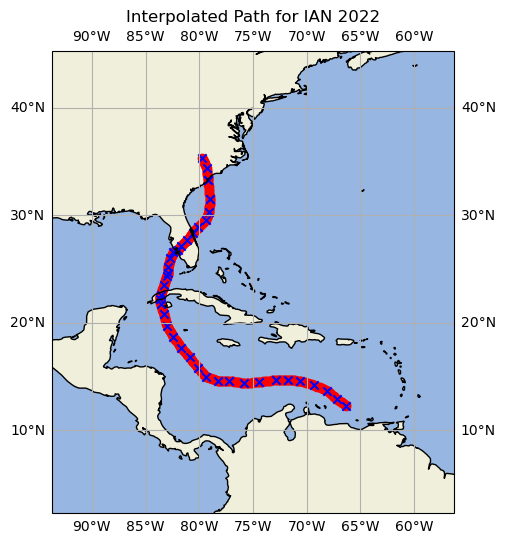

In [123]:
from helpers.hurricane_interpolation_helpers import HurricaneInterpolator
from helpers.tropycal_helpers import get_storm_list
import tropycal.tracks as tracks

hurricane_interpolator = HurricaneInterpolator()

interp_time_length = 30  # in minutes
storm_list = get_storm_list()
test_storm_name = "IAN" #storm_list["name"].iloc[20]
test_storm_year = 2022 #storm_list["year"].iloc[20]

basin = tracks.TrackDataset(basin='both')
storm = basin.get_storm((test_storm_name,test_storm_year))
storm_df = storm.to_dataframe()

interp_path_df = hurricane_interpolator.interpolate_path(test_storm_name, test_storm_year, storm_df, interp_time_length)
hurricane_interpolator.plot_interpolated_path(storm_df, interp_path_df)

wind_pressure_df = storm_df[["time","vmax","mslp"]]
full_ian_interp_df = hurricane_interpolator.interpolate_wind_and_pressure(interp_path_df,wind_pressure_df)

In [124]:
full_ian_interp_df

,storm_name,storm_year,time,lat,lon,vmax,mslp
0,IAN,2022,2022-09-22 18:00:00,12.300000,-66.300000,30,1006
1,IAN,2022,2022-09-22 18:30:00,12.350116,-66.374841,30,1006
2,IAN,2022,2022-09-22 19:00:00,12.400211,-66.449711,30,1006
3,IAN,2022,2022-09-22 19:30:00,12.450285,-66.524609,30,1006
4,IAN,2022,2022-09-22 20:00:00,12.500339,-66.599536,30,1006
...,...,...,...,...,...,...,...
403,IAN,2022,2022-10-01 04:00:00,35.000161,-79.565696,30,999
404,IAN,2022,2022-10-01 04:30:00,35.075136,-79.599180,30,999
405,IAN,2022,2022-10-01 05:00:00,35.150101,-79.632725,30,999
406,IAN,2022,2022-10-01 05:30:00,35.225056,-79.666331,30,999


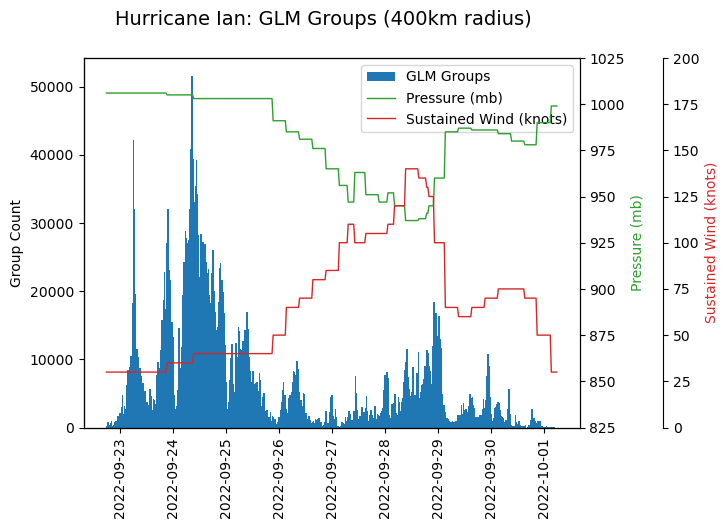

In [127]:
fig, ax = plt.subplots()

fig.suptitle("Hurricane Ian: GLM Groups (400km radius)", fontsize=14)


# Left axis: group count
ax.bar(
    hist_df['time'],
    hist_df['groups'],
    width=0.03,          # tune based on time resolution
    color='tab:blue',
    label='GLM Groups'
)
ax.set_ylabel('Group Count')
ax.tick_params(axis='y')
ax.tick_params(axis='x', labelrotation=90)

# Right axis 1: pressure
ax_r1 = ax.twinx()
ax_r1.plot(
    full_ian_interp_df['time'],
    full_ian_interp_df['mslp'],
    color='tab:green',
    label='Pressure (mb)',
    linewidth=1
)
ax_r1.set_ylim(825, 1025)
ax_r1.set_ylabel('Pressure (mb)', color='tab:green')
ax_r1.tick_params(axis='y')

# Right axis 2: wind speed
ax_r2 = ax.twinx()
ax_r2.plot(
    full_ian_interp_df['time'],
    full_ian_interp_df['vmax'],
    color='tab:red',
    label='Sustained Wind (knots)',
    linewidth=1
)
ax_r2.set_ylim(0, 200)
ax_r2.set_ylabel('Sustained Wind (knots)', color='tab:red')
ax_r2.tick_params(axis='y')
ax_r2.spines['right'].set_position(('outward', 60))

lines = []
labels = []

for a in [ax, ax_r1, ax_r2]:
    l, lab = a.get_legend_handles_labels()
    lines.extend(l)
    labels.extend(lab)

ax.legend(lines, labels, loc='best')


plt.show()